In [1]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# A function for plotting decision regions of classifiers.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.utils import check_Xy, format_kwarg_dictionaries
from math import floor
from math import ceil


def get_feature_range_mask(X, filler_feature_values=None,
                           filler_feature_ranges=None):
    """
    Function that constucts a boolean array to get rid of samples
    in X that are outside the feature range specified by filler_feature_values
    and filler_feature_ranges
    """

    if not isinstance(X, np.ndarray) or not len(X.shape) == 2:
        raise ValueError('X must be a 2D array')
    elif filler_feature_values is None:
        raise ValueError('filler_feature_values must not be None')
    elif filler_feature_ranges is None:
        raise ValueError('filler_feature_ranges must not be None')

    mask = np.ones(X.shape[0], dtype=bool)
    for feature_idx in filler_feature_ranges:
        feature_value = filler_feature_values[feature_idx]
        feature_width = filler_feature_ranges[feature_idx]
        upp_limit = feature_value + feature_width
        low_limit = feature_value - feature_width
        feature_mask = (X[:, feature_idx] > low_limit) & \
                       (X[:, feature_idx] < upp_limit)
        mask = mask & feature_mask

    return mask


def plot_decision_regions(X, y, clf,
                          feature_index=None,
                          filler_feature_values=None,
                          filler_feature_ranges=None,
                          ax=None,
                          X_highlight=None,
                          zoom_factor=1.,
                          legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                  '#9467bd,#8c564b,#e377c2,'
                                  '#7f7f7f,#bcbd22,#17becf'),
                          scatter_kwargs=None,
                          contourf_kwargs=None,
                          contour_kwargs=None,
                          scatter_highlight_kwargs=None):
    """Plot decision regions of a classifier.

    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.

    y : array-like, shape = [n_samples]
        True class labels.

    clf : Classifier object.
        Must have a .predict method.

    feature_index : array-like (default: (0,) for 1D, (0, 1) otherwise)
        Feature indices to use for plotting. The first index in
        `feature_index` will be on the x-axis, the second index will be
        on the y-axis.

    filler_feature_values : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted.

    filler_feature_ranges : dict (default: None)
        Only needed for number features > 2. Dictionary of feature
        index-value pairs for the features not being plotted. Will use the
        ranges provided to select training samples for plotting.

    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.

    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.

    zoom_factor : float (default: 1.0)
        Controls the scale of the x- and y-axis of the decision plot.

    hide_spines : bool (default: True)
        Hide axis spines if True.

    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.

    markers : str (default: 's^oxv<>')
        Scatterplot markers.

    colors : str (default: 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.

    scatter_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    contourf_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contourf function.

    contour_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contour function
        (which draws the lines between decision regions).

    scatter_highlight_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    Returns
    ---------
    ax : matplotlib.axes.Axes object

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/

    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]

    if ax is None:
        ax = plt.gca()

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X[:, x_index].min() - 1./zoom_factor,
                    X[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X[:, y_index].min() - 1./zoom_factor,
                        X[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict.astype(X.dtype))
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    contour_kwargs_default = {
        'linewidths': 0.5, 'colors': 'k', 'antialiased': True}
    contour_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contour_kwargs_default,
                        user_kwargs=contour_kwargs,
                        protected_keys=[])
    ax.contour(xx, yy, Z, cset.levels,
               **contour_kwargs)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': 'none',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

    if legend:
        if dim > 2 and filler_feature_ranges is None:
            pass
        else:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)

    return ax

ModuleNotFoundError: No module named 'mlxtend'

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier



In [8]:
url = 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt'
    
df = pd.read_table(url)  

In [9]:
X = df[['height', 'width', 'mass']].to_numpy()
y = df['fruit_label'].to_numpy()

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, y)

KNeighborsClassifier()

In [10]:
check_Xy(X, y, y_int=True)  # Validate X and y arrays
dim = X.shape[1]

In [11]:
dim

3

In [18]:
clf = knn

feature_index=[0,1]

# Decision region for feature 3 = mass = value
value=150
# Plot training sample with feature 3 = mass = value +/- width
width=100

filler_feature_values={2: value}  #these will be ignored
filler_feature_ranges={2: width}

ax=None
X_highlight=None

markers='s^oxv<>'
colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                  '#9467bd,#8c564b,#e377c2,'
                                  '#7f7f7f,#bcbd22,#17becf')
scatter_kwargs=None
contourf_kwargs=None
contour_kwargs=None

zoom_factor=1.
clf = knn

legend=1
hide_spines=True

/Users/Kaemyuijang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


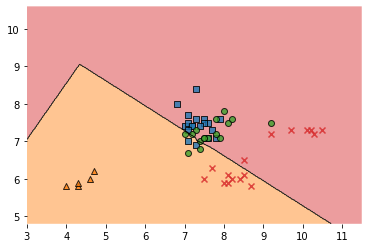

In [19]:

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    dim = X.shape[1]

    if ax is None:
        ax = plt.gca()

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X[:, x_index].min() - 1./zoom_factor,
                    X[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X[:, y_index].min() - 1./zoom_factor,
                        X[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = filler_feature_values[feature_idx]
    Z = clf.predict(X_predict.astype(X.dtype))
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    contour_kwargs_default = {
        'linewidths': 0.5, 'colors': 'k', 'antialiased': True}
    contour_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contour_kwargs_default,
                        user_kwargs=contour_kwargs,
                        protected_keys=[])
    ax.contour(xx, yy, Z, cset.levels,
               **contour_kwargs)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': 'none',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

In [20]:
X_predict_df = pd.DataFrame(X_predict,columns=['height', 'width', 'mass'])

In [21]:
X_predict_df.describe()

,height,width,mass
count,124416.000000,124416.000000,124416.0
mean,7.250000,7.700000,150.0
std,2.459435,1.680146,0.0
min,3.000000,4.800000,150.0
25%,5.125000,6.250000,150.0
50%,7.250000,7.700000,150.0
75%,9.375000,9.150000,150.0
max,11.500000,10.600000,150.0


In [22]:
Z

array([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [14]:

    if ax is None:
        ax = plt.gca()

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    if feature_index is not None:
        # Unpack and validate the feature_index values
        if dim == 1:
            raise ValueError(
                'feature_index requires more than one training feature')
        try:
            x_index, y_index = feature_index
        except ValueError:
            raise ValueError(
                'Unable to unpack feature_index. Make sure feature_index '
                'only has two dimensions.')
        try:
            X[:, x_index], X[:, y_index]
        except IndexError:
            raise IndexError(
                'feature_index values out of range. X.shape is {}, but '
                'feature_index is {}'.format(X.shape, feature_index))
    else:
        feature_index = (0, 1)
        x_index, y_index = feature_index

    # Extra input validation for higher number of training features
    if dim > 2:
        if filler_feature_values is None:
            raise ValueError('Filler values must be provided when '
                             'X has more than 2 training features.')

        if filler_feature_ranges is not None:
            if not set(filler_feature_values) == set(filler_feature_ranges):
                raise ValueError(
                    'filler_feature_values and filler_feature_ranges must '
                    'have the same keys')

        # Check that all columns in X are accounted for
        column_check = np.zeros(dim, dtype=bool)
        for idx in filler_feature_values:
            column_check[idx] = True
        for idx in feature_index:
            column_check[idx] = True
        if not all(column_check):
            missing_cols = np.argwhere(~column_check).flatten()
            raise ValueError(
                'Column(s) {} need to be accounted for in either '
                'feature_index or filler_feature_values'.format(missing_cols))

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X[:, x_index].min() - 1./zoom_factor,
                    X[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X[:, y_index].min() - 1./zoom_factor,
                        X[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))

    if dim == 1:
        X_predict = np.array([xx.ravel()]).T
    else:
        X_grid = np.array([xx.ravel(), yy.ravel()]).T
        X_predict = np.zeros((X_grid.shape[0], dim))
        X_predict[:, x_index] = X_grid[:, 0]
        X_predict[:, y_index] = X_grid[:, 1]
        if dim > 2:
            for feature_idx in filler_feature_values:
                X_predict[:, feature_idx] = np.random.uniform(low=30.0, high=200.0) #100.  #filler_feature_values[feature_idx]
    #X_predict =np.random.uniform(low=80.0, high=150.0,size=len(X_predict))
    X_predict[:,2]=np.random.uniform(low=30.0, high=200.0,size=len(X_predict))
    print(X_predict)
    print(np.random.uniform(low=30.0, high=200.0,size=len(X_predict)))
    print(len(X_predict.astype(X.dtype)))
    Z = clf.predict(X_predict.astype(X.dtype))
    Z = Z.reshape(xx.shape)
    # Plot decisoin region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    contour_kwargs_default = {
        'linewidths': 0.5, 'colors': 'k', 'antialiased': True}
    contour_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contour_kwargs_default,
                        user_kwargs=contour_kwargs,
                        protected_keys=[])
    ax.contour(xx, yy, Z, cset.levels,
               **contour_kwargs)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    for idx, c in enumerate(np.unique(y)):
        if dim == 1:
            y_data = [0 for i in X[y == c]]
            x_data = X[y == c]
        elif dim == 2:
            y_data = X[y == c, y_index]
            x_data = X[y == c, x_index]
        elif dim > 2 and filler_feature_ranges is not None:
            class_mask = y == c
            feature_range_mask = get_feature_range_mask(
                            X, filler_feature_values=filler_feature_values,
                            filler_feature_ranges=filler_feature_ranges)
            y_data = X[class_mask & feature_range_mask, y_index]
            x_data = X[class_mask & feature_range_mask, x_index]
        else:
            continue

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        if dim == 1:
            x_data = X_highlight
            y_data = [0 for i in X_highlight]
        elif dim == 2:
            x_data = X_highlight[:, x_index]
            y_data = X_highlight[:, y_index]
        else:
            feature_range_mask = get_feature_range_mask(
                    X_highlight, filler_feature_values=filler_feature_values,
                    filler_feature_ranges=filler_feature_ranges)
            y_data = X_highlight[feature_range_mask, y_index]
            x_data = X_highlight[feature_range_mask, x_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': 'none',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)


AttributeError: 'list' object has no attribute 'split'

In [15]:
Z

array([[1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [143]:
np.random.uniform(low=30.0, high=200.0,size=3)

array([ 52.84948644,  54.09262965, 156.69533944])

In [144]:
np.unique(Z)

array([1, 3])

In [145]:
temp = X_predict

In [146]:
len(temp)

124416

In [147]:
np.random.uniform(low=30.0, high=200.0,size=len(temp))

array([ 74.41930614,  67.27784808, 159.41237535, ..., 176.23613314,
       153.25564871, 135.57282253])

In [148]:
temp[:,2] =np.random.uniform(low=30.0, high=200.0,size=len(temp))

In [149]:
temp

array([[  3.        ,   4.8       ,  33.87663814],
       [  3.01972158,   4.8       , 127.02086637],
       [  3.03944316,   4.8       , 193.08511088],
       ...,
       [ 11.46055684,  10.6       ,  89.54586798],
       [ 11.48027842,  10.6       , 135.38731397],
       [ 11.5       ,  10.6       , 197.49842499]])

In [153]:
X_predict_df = pd.DataFrame(X_predict,columns=['height', 'width', 'mass'])

In [154]:
X_predict_df.describe()

,height,width,mass
count,124416.000000,124416.000000,124416.0
mean,7.250000,7.700000,100.0
std,2.459435,1.680146,0.0
min,3.000000,4.800000,100.0
25%,5.125000,6.250000,100.0
50%,7.250000,7.700000,100.0
75%,9.375000,9.150000,100.0
max,11.500000,10.600000,100.0


In [152]:
temp[:,2]=100

In [56]:
temp

array([[  3.        ,   4.8       , 100.        ],
       [  3.01972158,   4.8       , 100.        ],
       [  3.03944316,   4.8       , 100.        ],
       ...,
       [ 11.46055684,  10.6       , 100.        ],
       [ 11.48027842,  10.6       , 100.        ],
       [ 11.5       ,  10.6       , 100.        ]])